In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import time
import pickle
# import json
import importlib
import matplotlib.pyplot as plt

from config import ms_coco_dir

import pylab
pylab.rcParams['figure.figsize'] = (8.0, 5.5)

In [10]:
# use xception descriptors

xc_train = pickle.load(open(ms_coco_dir + '/descriptors/xception/xception-train2017-descriptors.pic', 'rb'))
xc_val = pickle.load(open(ms_coco_dir + '/descriptors/xception/xception-val2017-descriptors.pic', 'rb'))

descriptors_train = xc_train
descriptors_val = xc_val

## Train

Or skip this and just load some model in the inference section

In [43]:
freq_threshold = 0
train_size = 100
num_steps = 50

embeding_size = 200
batch_size = 5
lstm_size = 200
checkpoint_path = 'checkpoints/coco-caption.ckp'
image_descriptor_size = X_images.shape[1]

In [44]:
import utils
importlib.reload(utils)
from utils import load_and_save_captions, load_captions_and_images

# load_and_save_captions(ms_coco_dir, train_size, num_steps, freq_threshold)
X_images, X_captions, Y, X_lens, vocab_size, caption_ids = load_captions_and_images(descriptors_train)

In [45]:
X_images.shape, X_captions.shape, vocab_size

((100, 2048), (100, 50), 16255)

In [11]:
from lstm_captioning_model import RNNCaptioningModel

In [12]:
tf.reset_default_graph()
sess = tf.Session()
model = RNNCaptioningModel(embedding_size=embeding_size, image_descriptor_size=image_descriptor_size, lstm_size=lstm_size, num_steps=num_steps, vocab_size=vocab_size, sess=sess, checkpoint_path=checkpoint_path)
model.build(model_type='train')

In [13]:
sess.run(tf.global_variables_initializer())
# model.saver.restore(sess, checkpoint_path + '-final') # continue training

In [14]:
n_epochs = 10
learning_rate = 0.001
model.train(X_images, X_captions, Y, X_lens, n_epochs, batch_size, learning_rate, evaluate_every=20, save_every=100)

n_epochs = 20
learning_rate = 0.0001
model.train(X_images, X_captions, Y, X_lens, n_epochs, batch_size, learning_rate, evaluate_every=20, save_every=100)

epoch 1
training loss after 20 steps: 3.68624687195 elapsed time: 00h 00m 03s
epoch 2
training loss after 40 steps: 2.50168204308 elapsed time: 00h 00m 06s
epoch 3
training loss after 60 steps: 1.75109219551 elapsed time: 00h 00m 10s
epoch 4
training loss after 80 steps: 1.17539286613 elapsed time: 00h 00m 13s
epoch 5
training loss after 100 steps: 0.761193573475 elapsed time: 00h 00m 16s
saved model to checkpoints/coco-caption.ckp-100
epoch 6
training loss after 120 steps: 0.517965734005 elapsed time: 00h 00m 21s
epoch 7
training loss after 140 steps: 0.380921781063 elapsed time: 00h 00m 24s
epoch 8
training loss after 160 steps: 0.321037262678 elapsed time: 00h 00m 28s
epoch 9
training loss after 180 steps: 0.304425597191 elapsed time: 00h 00m 31s
epoch 10
training loss after 200 steps: 0.24826925993 elapsed time: 00h 00m 34s
saved model to checkpoints/coco-caption.ckp-200
Finished training
Saved final model to checkpoints/coco-caption.ckp-final
Final training loss: 0.248269230127
It

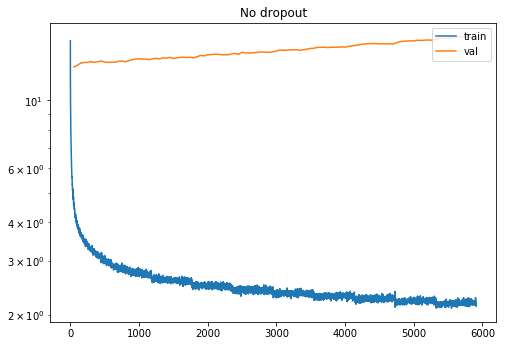

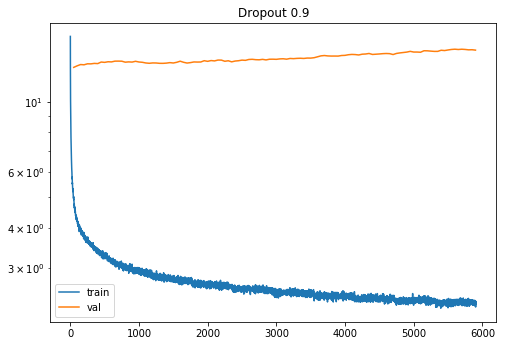

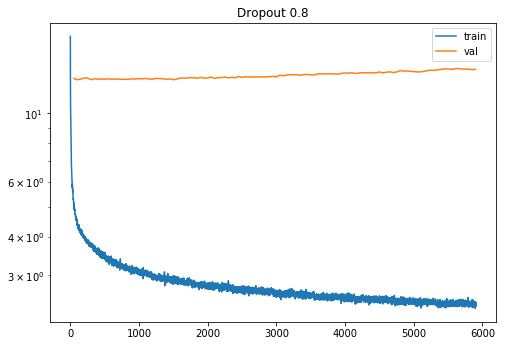

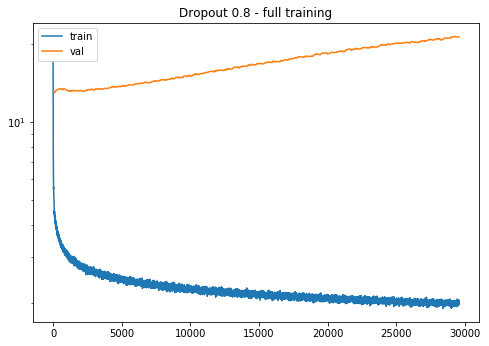

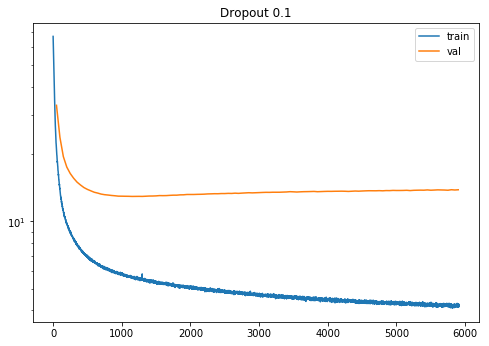

In [25]:
losses, losses_x, losses_val, losses_val_x = np.load('run-1/losses.npy')
plt.figure()
plt.title('No dropout')
plt.semilogy(losses_x, losses, label='train')
plt.semilogy(losses_val_x, losses_val, label='val')
plt.legend(loc='upper right')

losses, losses_x, losses_val, losses_val_x = np.load('run-3/losses.npy')
plt.figure()
plt.title('Dropout 0.9')
plt.semilogy(losses_x, losses, label='train')
plt.semilogy(losses_val_x, losses_val, label='val')
plt.legend()

losses, losses_x, losses_val, losses_val_x = np.load('run-5/losses.npy')
plt.figure()
plt.title('Dropout 0.8')
plt.semilogy(losses_x, losses, label='train')
plt.semilogy(losses_val_x, losses_val, label='val')
plt.legend()

losses, losses_x, losses_val, losses_val_x = np.load('run-4/losses.npy')
plt.figure()
plt.title('Dropout 0.8 - full training')
plt.semilogy(losses_x, losses, label='train')
plt.semilogy(losses_val_x, losses_val, label='val')
plt.legend()

losses, losses_x, losses_val, losses_val_x = np.load('run-2/losses.npy')
plt.figure()
plt.title('Dropout 0.1')
plt.semilogy(losses_x, losses, label='train')
plt.semilogy(losses_val_x, losses_val, label='val')
plt.legend()

## Infer

In [3]:
# We need to download the vocab, because the tokenization is done differently there than on my laptop (don't know why).
with open('vocab-train2017.pic', 'rb') as f:
    vocab = pickle.load(f)
id_word = [v[0] for v in vocab]
word_id = {w:i for i,w in enumerate(id_word)}
vocab_size = len(vocab)
vocab_size

16255

In [6]:
# freq_threshold = 0
# train_size = 100
num_steps = 50

embeding_size = 512
batch_size = 1000
lstm_size = 512
checkpoint_path = 'run-4/coco-caption.ckp-final'
image_descriptor_size = 2048

In [7]:
import lstm_captioning_model
importlib.reload(lstm_captioning_model)
from lstm_captioning_model import RNNCaptioningModel

tf.reset_default_graph()
sess = tf.Session()
model = RNNCaptioningModel(embedding_size=embeding_size, image_descriptor_size=image_descriptor_size, lstm_size=lstm_size, num_steps=num_steps, vocab_size=vocab_size, sess=sess, checkpoint_path=checkpoint_path)
model.build(model_type='infer')
model.saver.restore(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from run-4/coco-caption.ckp-final


In [20]:
dataType = 'val2017'
descriptors = descriptors_val

from pycocotools.coco import COCO
coco = COCO(ms_coco_dir + '/annotations/captions_' + dataType + '.json')

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


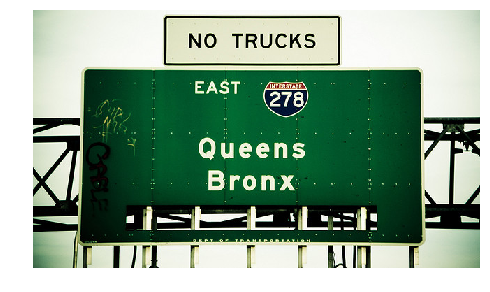

PRED: A very close up view of a sign across a street .
TRUE: The road sign says "East 278 Queens Bronx"
TRUE: A highway road sign directing the way ahead.
TRUE: A large and green interstate exit sign above a road.
TRUE: A green road sign showing the Queens Bronx exit.
TRUE: An green and white overhead street sign on Interstate 278 for Queens and Bronx, showing a truck restriction.

---



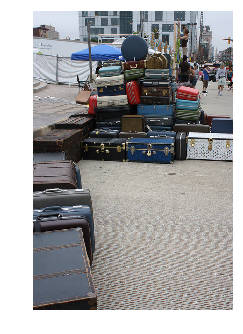

PRED: several vintage suitcases stacked up on a bench
TRUE: very many travelling bags placed on the floor
TRUE: Piles of luggage sit outside on a busy street. 
TRUE: A large stack of trunks and luggage on a sidewalk with people behind it.
TRUE: a sidewalk filled with various bags and cases of luggage
TRUE: There are lots and lots of suitcases stacked up together.

---



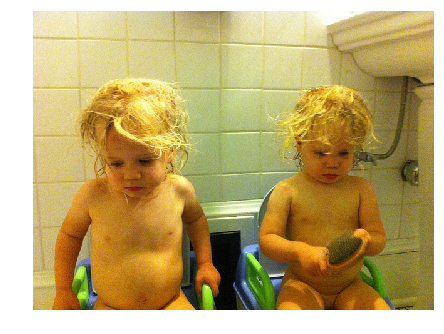

PRED: A woman , a young girl and boy hold Frisbees , other different types of pizza .
TRUE: Two naked babies on training toilets in a bathroom
TRUE: A couple of little girls sitting next to each other in a bathroom.
TRUE: Two children are practicing using the potty next to each other.
TRUE: Two babies sitting on their potties in the bathroom. 
TRUE: A set of twins who are taking a bath.

---



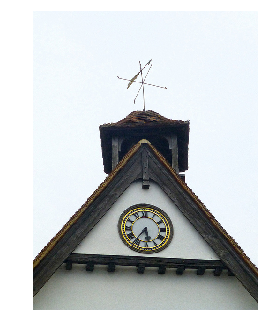

PRED: Tall clock with clock hanging from the ceiling .
TRUE: A building with a very pointy roof and a clock.
TRUE: Gold trimmed clock on top  of roof of building
TRUE: The clock is built near the roof of a building.
TRUE: a clock on a building with a sky background
TRUE: We are looking up at a clock in the peak of a roof.

---



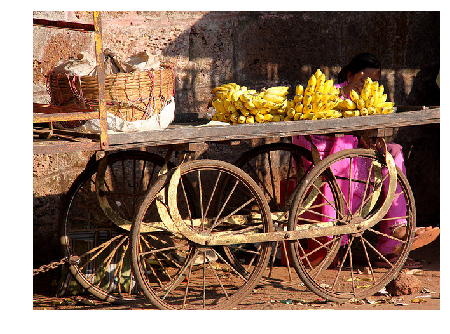

PRED: A suitcase is full of bananas on a sidewalk .
TRUE: A wooden wagon with wheels topped with bunches of bananas.
TRUE: a small wooden cart with a bunch of bananas on it
TRUE: Old wooden wagon with banana bunches on it
TRUE: There are many bananas being laid on the wagon.
TRUE: A flat bed cart with three large bunches of bananas and a tied lidded basket.

---



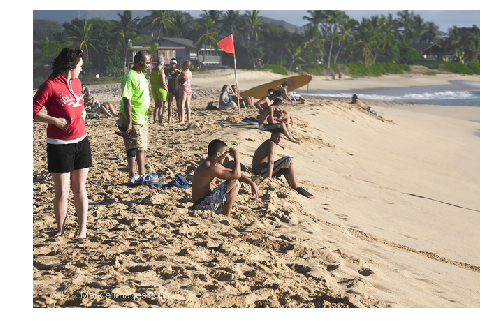

PRED: Man and girl on the beach are carrying surf boards .
TRUE: a few people that are standing on a beach
TRUE: A group of people on a beach looking towards the water. 
TRUE: Several people are shown sitting in the sand at the beach.
TRUE: aer of people sitting down on a beach near water 
TRUE: People are sitting on the sand at the beach 

---



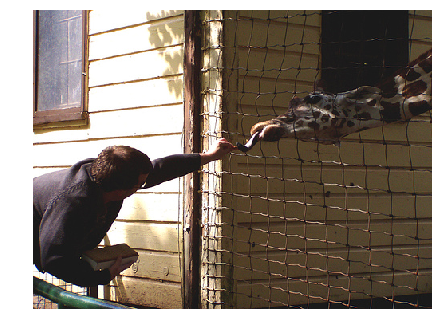

PRED: A man standing on a ledge next to a cow tower .
TRUE: A giraffe sticks his nose and tongue out of a wire fence to accept something a man is offering him.
TRUE: A giraffe eating out of the hands of a man through fence.
TRUE: A man in black sweater feeding a giraffe through a fence.
TRUE: A man feeding a giraffe through a metal fence
TRUE: A man feeding a giraffe through a fence.

---



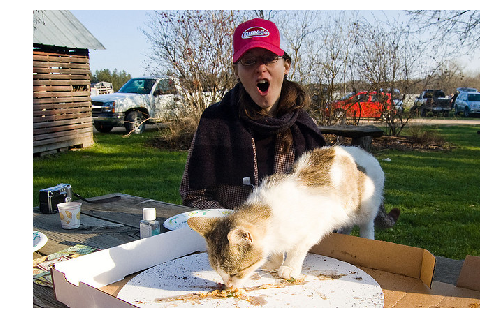

PRED: a dog sits on a bench in the woods
TRUE: A woman in black jacket watching a cat eating from pizza box.
TRUE: A woman looking at a cat licking pizza grease
TRUE: A woman holding a white and brown cat.
TRUE: A man sitting at a table with a cat eating food.
TRUE: A woman looking with shock as a cat eats a pizza.

---



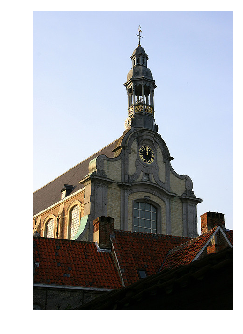

PRED: A tall mountain that has a clock on top
TRUE: A very tall church with a clock below a tower.
TRUE: a building that has a large clock on it
TRUE: an ornate clock and watchtower on top of a building
TRUE: A large building can be seen in the background with a clock on it's face.
TRUE: A spire over a beautiful brick building behind red tiled roofs.

---



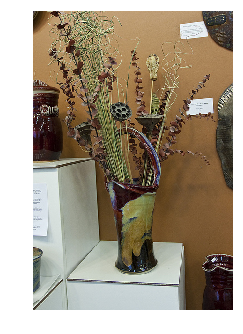

PRED: A white vase filled with pink and purple flowers .
TRUE: A vase with various flowers in it on a display case.
TRUE: a vase with flowers on a display near a wall
TRUE: The vase is holding an arrangement of dried vines. 
TRUE: an image of a flower arrangement in the vase
TRUE: A vase full of flowers is sitting on display.

---



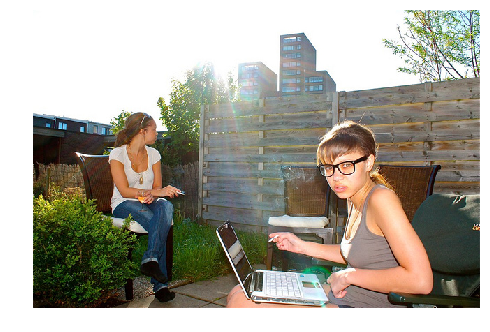

PRED: A woman sitting on a bench at a park , someone taking pictures .
TRUE: Two women sitting outside hanging out and smoking cigarettes.
TRUE: a couple of women sitting outside in a court yard 
TRUE: Young women having a cigarette in their back yard
TRUE: Two girls sitting outisde smoking and one girl on a laptop.
TRUE: Two girls are smoking cigarettes while one is playing on the laptop.

---



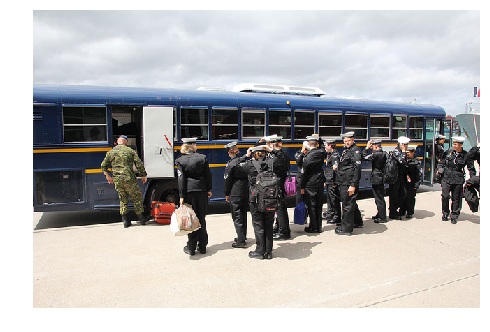

PRED: Three people are looking at vehicles on a train .
TRUE: A group of people in uniforms stand in formation next to a bus
TRUE: A group of people in military uniform stand outside a bus. 
TRUE: Young servicemen and servicewomen stand next to a blue bus with luggage.  
TRUE: People in uniform standing in front of a bus.
TRUE: military people getting off and on the train.

---



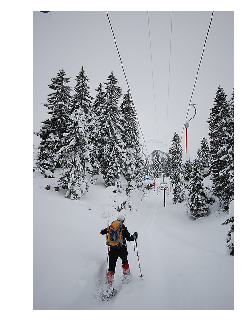

PRED: Altered photograph of a skier passing by a grey wall
TRUE: A person on skis sliding up down a path.
TRUE: A man is cross country skiing in the snow.
TRUE: Person skiing on snowy slopes with wires above
TRUE: A man is skiing on a snowy slope.
TRUE: A skier makes his way up a snowy hill, eschewing the lift. 

---



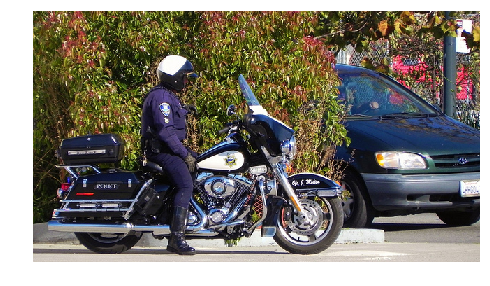

PRED: Motorcyclists are gathered while sitting on a bench .
TRUE: a traffic motorcycle cop waits to give a ticket
TRUE: A police officer on a motorcycle sitting at the corner. 
TRUE: A police officer is outside on his bike.
TRUE: Police officer laying a speed trap for the purpose of writing a ticket.
TRUE: A police man on a motorcycle is idle in front of a bush.

---



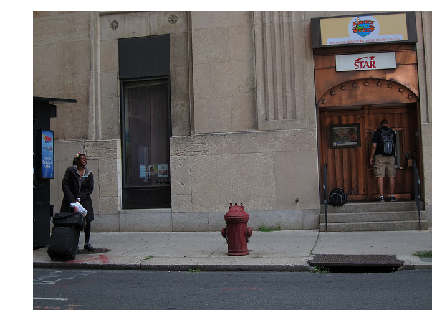

PRED: A tall outdoor bench and sign that is on a pole .
TRUE: Two people outside of a stone building near a red fire hydrant.
TRUE: There are two people standing on the side of a street.
TRUE: a woman is pulling luggage on to a sidewalk near a fire hydrant
TRUE: Man and woman with luggage near a doorway on a city street.
TRUE: a city scene of a sidewalk with a red fire hydrant on a sidewalk next to an ATM

---



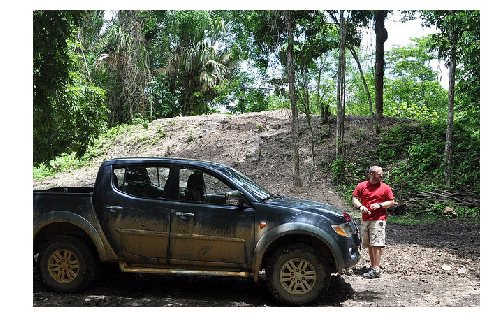

PRED: An obese man rides a bicycle swiftly down a road .
TRUE: A man standing next to a truck near a forest hillside.
TRUE: A man standing next to a muddy pick up truck.
TRUE: A man stands in front of a pickup truck.
TRUE: A man and his truck on a trail in a forest.
TRUE: A muddied man standing next to a muddied truck.

---



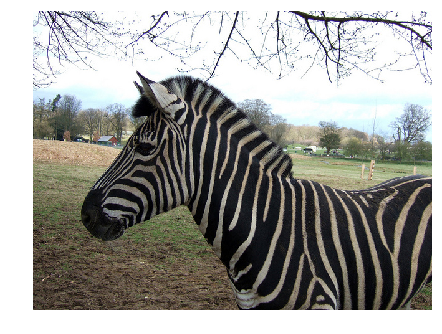

PRED: A couple of zebra standing next to each other .
TRUE: A zebra standing on top of a grass covered field.
TRUE: there is a very beautiful zebra that is standing in the shade
TRUE: A zebra showing the left side of itself on a field.
TRUE: A zebra is standing in an open field.
TRUE: a large zebra standing next to a tree

---



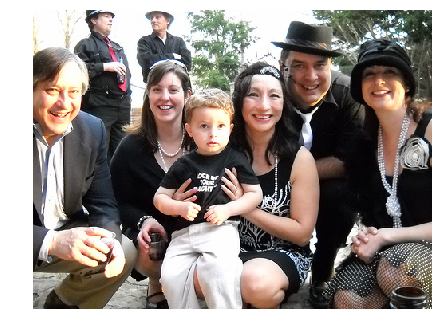

PRED: Two young women holding tennis rackets , pose for a picture .
TRUE: A group of people posing for a photograph at a black tie event.
TRUE: A group of hipsters kneeling down next to each other.
TRUE: A group of people posing for a photo.
TRUE: A group of people seated on a bench posing for a photo
TRUE: some adults and a child are in a photograph

---



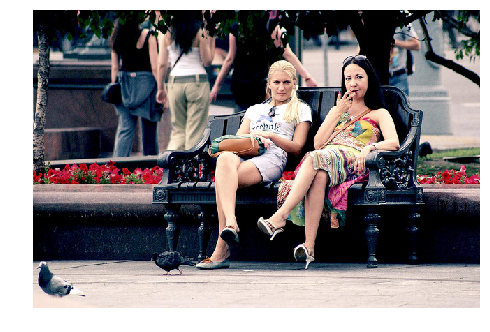

PRED: Two people sitting on a bench while a girl sitting in a chair laughing .
TRUE: Two sexy young women sitting on a metal bench in front of flowers.
TRUE: Two women sitting on a metal park bench
TRUE: Two people sit on a bench with pigeons and other people nearby.
TRUE: Two women sitting on a bench in the park.
TRUE: Two women sitting on a bench with one smoking a cigarette.

---



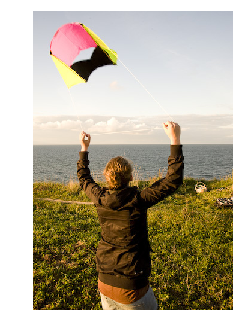

PRED: A lady in a red shirt is flying a kite
TRUE: Young man flying a kite over a grassy area by water.
TRUE: A young girl flies a kite in the grass by the water.
TRUE: A man is flying a kite in the middle of a field next to the ocean.
TRUE: A person playing with a kite near the beach
TRUE: A young woman flies a kite near a body of water.

---



In [28]:
from skimage import io

num_sentences = 20

imgIds = coco.getImgIds()
# imgIds = caption_ids

for i in range(num_sentences):
    idx = np.random.choice(imgIds)
    
    img = coco.loadImgs([idx])[0]
    I = io.imread('%s/images/%s/%s' % (ms_coco_dir, dataType, img['file_name']))
    plt.figure()
    plt.axis('off')
    plt.imshow(I)
    plt.show()
    
    seqs = model.infer(descriptors[idx].reshape(1,-1), start_id=word_id['START'], end_id=word_id['END'])
    seq = seqs[0]
    print('PRED:', ' '.join([id_word[w] for w in seq if id_word[w] not in ('START', 'END')]))
    
    annIds = coco.getAnnIds(imgIds=[idx])
    anns = coco.loadAnns(annIds)
    for a in anns:
        print('TRUE:', a['caption'])
    print()
    print('---')
    print()